In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf

### EDA

Pull in data.

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Descriptive statistics.

In [3]:
round(data.describe(), 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


Feature distributions.

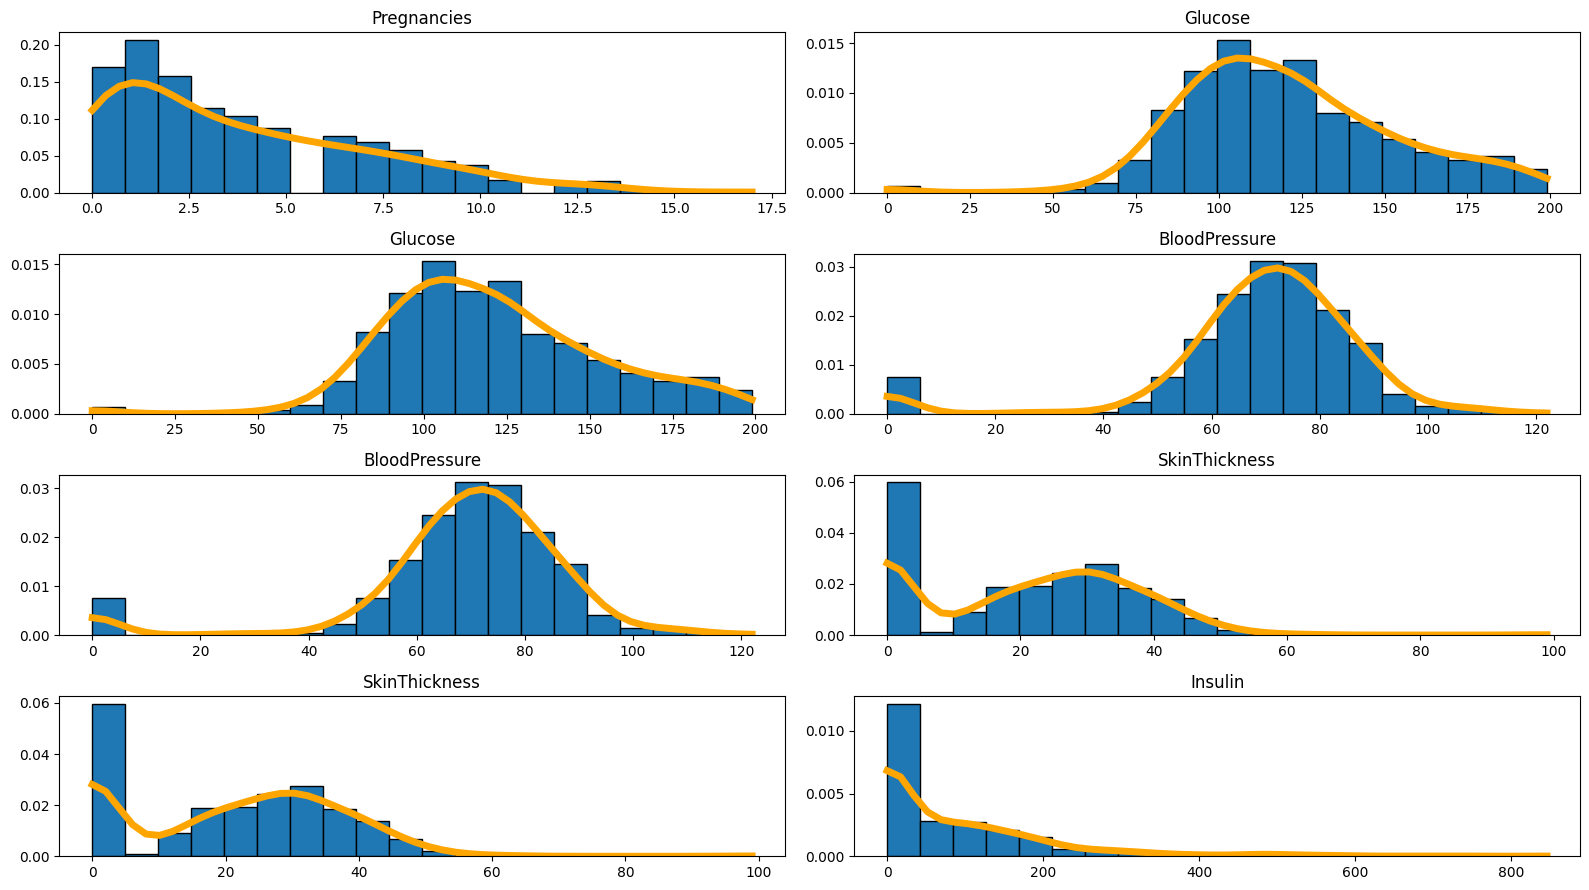

In [4]:
fig, axs = plt.subplots(4, 2, figsize=[16,9])

for i in range(4):
    for j in range(2):
        col = data.iloc[:,i + j]
        
        axs[i][j].hist(col, bins=20, edgecolor='black', density=True)
        
        x = ss.gaussian_kde(col)
        lin = np.linspace(col.min(), col.max(), 50)
        
        axs[i][j].plot(lin, x(lin), color='orange', linewidth=5)
        axs[i][j].set_title(col.name)
        
fig.tight_layout()
plt.show()

Outcome is the target label we are trying to predict. We see that roughly a third of the patients in the data set have a positive diabetes test.

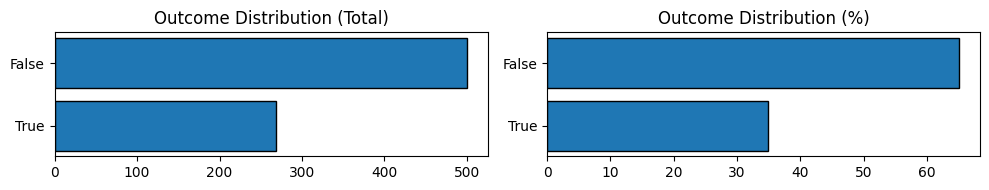

In [5]:
fig, axs = plt.subplots(1, 2, figsize=[10,2])

axs[0].barh([0, 1], [(data['Outcome'] == True).sum(), (data['Outcome'] == False).sum()], edgecolor='Black')
axs[1].barh([0, 1], [100 * (data['Outcome'] == True).sum() / len(data), 100 * (data['Outcome'] == False).sum() / len(data)], edgecolor='Black')
axs[0].set_yticks([0, 1], labels=['True', 'False'])
axs[1].set_yticks([0, 1], labels=['True', 'False'])
axs[0].set_title('Outcome Distribution (Total)')
axs[1].set_title('Outcome Distribution (%)')
fig.tight_layout()
plt.show()

### Data Cleaning

In [6]:
X = data.drop(columns=['Outcome'])
y = data[['Outcome']]

We will split the data into a training set (60%), a test set (20%), and a validation set (20%).

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=11)
eval_set = [(X_train, y_train), (X_val,y_val)]

### Model Fitting

We will be using TensorFlow to implement our neural network model. Our model will use two hidden layers that both have a relu activation functions and then an output layer that uses the sigmoid function. We use the sigmoid function in the output layer because we are performing a classification exercise.

In [59]:
def create_model(learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(8,)))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)     # Use .legacy version on M1/M2 Macs
    loss = tf.keras.losses.BinaryCrossentropy()

    model.compile(loss=loss, optimizer=optimizer)

    return model

In [64]:
def process_data(X):
    normalize = tf.keras.layers.Normalization(axis=1)
    normalize.adapt(X_train)
    X_norm = normalize(X_train)

    return X_norm

In [73]:
X_train_norm = process_data(X_train)
X_val_norm = process_data(X_val)

In [66]:
learning_rate=.1
model = create_model(learning_rate)
model.fit(X_train_norm, y_train, epochs=25, batch_size=10)

Epoch 1/25
46/46 [==============================] - 0s 448us/step - loss: 0.5671
Epoch 2/25
46/46 [==============================] - 0s 403us/step - loss: 0.5155
Epoch 3/25
46/46 [==============================] - 0s 348us/step - loss: 0.5411
Epoch 4/25
46/46 [==============================] - 0s 382us/step - loss: 0.5191
Epoch 5/25
46/46 [==============================] - 0s 375us/step - loss: 0.5051
Epoch 6/25
46/46 [==============================] - 0s 381us/step - loss: 0.4767
Epoch 7/25
46/46 [==============================] - 0s 383us/step - loss: 0.4620
Epoch 8/25
46/46 [==============================] - 0s 381us/step - loss: 0.4888
Epoch 9/25
46/46 [==============================] - 0s 370us/step - loss: 0.4725
Epoch 10/25
46/46 [==============================] - 0s 379us/step - loss: 0.4386
Epoch 11/25
46/46 [==============================] - 0s 336us/step - loss: 0.4560
Epoch 12/25
46/46 [==============================] - 0s 398us/step - loss: 0.4792
Epoch 13/25
46/46 [======

Here are the different hyperparameter values that we will optimize the model to.

In [89]:
parameters = {'learning_rate' : [.5, .3, .1, .01],
              'epochs' : [25, 50, 100, 150],
              'batch_size' : [0.1, 0.2, 0.3, 0.4]
}

In [101]:
scores = {}

total = 1
for i in parameters.values():
    total *= len(i)

print('Models Fitted: %d/%d (%.2f%%)' % (0, total, 0), end='\r')
count = 1
for learning_rate in parameters['learning_rate']:
    for epochs in parameters['epochs']:
        for batch_size in parameters['batch_size']:
            model = create_model(learning_rate)
            model.fit(X_train_norm, y_train, verbose=0)
                                 
            val_pred = model.predict(X_val, verbose=0)
            val_pred = val_pred > 0.5
            score = val_pred == y_val

            scores.update({(learning_rate, epochs, batch_size) : score.sum() / len(score)})

            print('Models Fitted: %d/%d (%.2f%%)' % (count, total, 100 * count / total), end='\r')
            count += 1

In [108]:
results = pd.DataFrame(scores).T
results = results.reset_index()
results.columns = ['learning_rate', 'epochs', 'batch_size', 'Score']
results = results.sort_values('Score', ascending=False)
results.head()

,learning_rate,epochs,batch_size,Score
14,0.5,150,0.3,0.714286
0,0.5,25,0.1,0.701299
2,0.5,25,0.3,0.701299
3,0.5,25,0.4,0.701299
4,0.5,50,0.1,0.701299


In [115]:
print('Our best model has the following parameters')
print(round(results.iloc[0][:3], 2).to_dict())

Our best model has the following parameters
{'learning_rate': 0.5, 'epochs': 150.0, 'batch_size': 0.3}


In [12]:
print('The model with the lowest loss has an AUC score of %.6f with parameters' % grid.best_score_)
for key, value in grid.best_params_.items():
    print(key, '=', value)

The model with the lowest loss has an AUC score of 0.844220 with parameters
colsample_bytree = 0.6
gamma = 0
learning_rate = 0.5
max_depth = 4
max_leaves = 2
n_estimators = 10


In [13]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for i in range(len(means)):
    print('Score: %.6f, StD. % .6f, Parameters' % (means[i], stds[i]), params[i])

Score: 0.760702, StD.  0.020442, Parameters {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 1.0, 'max_depth': 4, 'max_leaves': 0, 'n_estimators': 10}
Score: 0.760702, StD.  0.020442, Parameters {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 1.0, 'max_depth': 4, 'max_leaves': 0, 'n_estimators': 25}
Score: 0.760702, StD.  0.020442, Parameters {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 1.0, 'max_depth': 4, 'max_leaves': 0, 'n_estimators': 50}
Score: 0.760702, StD.  0.020442, Parameters {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 1.0, 'max_depth': 4, 'max_leaves': 0, 'n_estimators': 75}
Score: 0.828386, StD.  0.016897, Parameters {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 1.0, 'max_depth': 4, 'max_leaves': 2, 'n_estimators': 10}
Score: 0.828386, StD.  0.016897, Parameters {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 1.0, 'max_depth': 4, 'max_leaves': 2, 'n_estimators': 25}
Score: 0.828386, StD.  0.016897, Parameters {'colsample_by

We have the best hyperparameters from the grid search. We create a fresh model with those hyperparameters and train it on our training data.

In [14]:
model = XGBClassifier(tree_method='hist',
                      verbosity=2,
                      n_estimators=grid.best_params_['n_estimators'],
                      max_depth=grid.best_params_['max_depth'],
                      max_leaves=grid.best_params_['max_leaves'],
                      learning_rate=grid.best_params_['learning_rate'],
                      colsample_bytree=grid.best_params_['colsample_bytree'],
                      gamma=grid.best_params_['gamma'],
                      early_stopping_rounds=8,
                      eval_metric='auc')

In [15]:
model.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-auc:0.70383	validation_1-auc:0.67593
[1]	validation_0-auc:0.77602	validation_1-auc:0.74356
[2]	validation_0-auc:0.82325	validation_1-auc:0.76711
[3]	validation_0-auc:0.85219	validation_1-auc:0.78996
[4]	validation_0-auc:0.85357	validation_1-auc:0.78563
[5]	validation_0-auc:0.86076	validation_1-auc:0.79116
[6]	validation_0-auc:0.87345	validation_1-auc:0.79036
[7]	validation_0-auc:0.87492	validation_1-auc:0.80435
[8]	validation_0-auc:0.87793	validation_1-auc:0.80435
[9]	validation_0-auc:0.87971	validation_1-auc:0.81089


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=8,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

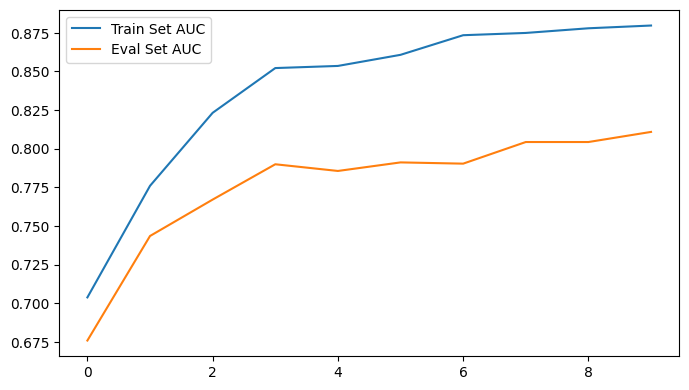

In [16]:
results = model.evals_result()

plt.figure(figsize=[8,4.5])
plt.plot(results['validation_0']['auc'], label='Train Set AUC')
plt.plot(results['validation_1']['auc'], label='Eval Set AUC')
plt.legend()
plt.show()

Below is an example of one of our trees.

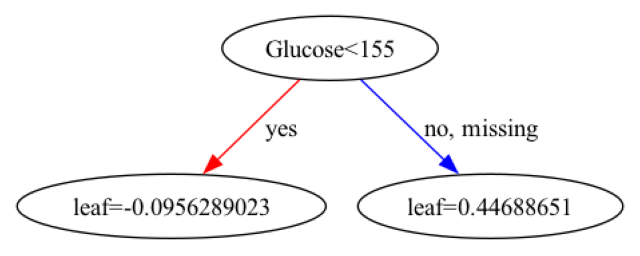

In [34]:
# This cell needs graphviz to be installed
fig, ax = plt.subplots(figsize=(8, 4.5))
plot_tree(model, num_trees=9, ax=ax)
plt.show()

We will assume that a prediction probability of 0.5 or greater is classified as True and anything else as False.

In [18]:
preds_test = model.predict_proba(X_test)
results_test = pd.DataFrame({'Target' : np.array(y_test).T[0], 'True Prob' : preds_test[:,1], 'False Prob' : preds_test[:,0]})
results_test['Target'] = results_test['Target'].astype(bool)
results_test['Prediction'] = results_test['True Prob'] >= .5
results_test['Correct'] = results_test['Target'] == results_test['Prediction']
results_test.head()

,Target,True Prob,False Prob,Prediction,Correct
0,True,0.143382,0.856618,False,False
1,False,0.103217,0.896783,False,True
2,False,0.103217,0.896783,False,True
3,True,0.805663,0.194337,True,True
4,True,0.545999,0.454001,True,True


In [19]:
a = 100 * results_test[results_test['Target'] == True]['Correct'].sum() / len(results_test[results_test['Target'] == True])
print('Guessed Test True Correctly %.2f%%' % a)
b = 100 * results_test[results_test['Target'] == False]['Correct'].sum() / len(results_test[results_test['Target'] == False])
print('Guessed Test False Correctly %.2f%%' % b)
c = 100 * results_test['Correct'].sum() / len(results_test)
print('Guessed Test Correctly %.2f%%' % c)

Guessed Test True Correctly 46.67%
Guessed Test False Correctly 89.36%
Guessed Test Correctly 72.73%


In [20]:
preds_train = model.predict_proba(X_train)
results_train = pd.DataFrame({'Target' : np.array(y_train).T[0], 'True Prob' : preds_train[:,1], 'False Prob' : preds_train[:,0]})
results_train['Target'] = results_train['Target'].astype(bool)
results_train['Prediction'] = results_train['True Prob'] >= .5
results_train['Correct'] = results_train['Target'] == results_train['Prediction']
results_train.head()

,Target,True Prob,False Prob,Prediction,Correct
0,True,0.864565,0.135435,True,True
1,False,0.352345,0.647655,False,True
2,False,0.183892,0.816108,False,True
3,False,0.190139,0.809861,False,True
4,True,0.432816,0.567184,False,False


In [21]:
a = 100 * results_train[results_train['Target'] == True]['Correct'].sum() / len(results_train[results_train['Target'] == True])
print('Guessed Train True Correctly %.2f%%' % a)
b = 100 * results_train[results_train['Target'] == False]['Correct'].sum() / len(results_train[results_train['Target'] == False])
print('Guessed Train False Correctly %.2f%%' % b)
c = 100 * results_train['Correct'].sum() / len(results_train)
print('Guessed Train Correctly %.2f%%' % c)

Guessed Train True Correctly 54.94%
Guessed Train False Correctly 92.95%
Guessed Train Correctly 79.57%


We see that our model predicts better on our training data than on our test data, which is expected. However, the model is still able to predict diabetes correctly in +70% of our test instances, which is a reasonable result.

In [22]:
preds_val = model.predict_proba(X_val)
results_val = pd.DataFrame({'Target' : np.array(y_val).T[0], 'True Prob' : preds_val[:,1], 'False Prob' : preds_val[:,0]})
results_val['Target'] = results_val['Target'].astype(bool)
results_val['Prediction'] = results_val['True Prob'] >= .5
results_val['Correct'] = results_val['Target'] == results_val['Prediction']

Here we look at the ROC Curve. If our curve was simply a straight diagonal line $(y=x)$, our model would have no predictive power, i.e. when the threshold of predicting a positive result vs. a negative result is raised our model's performance improves linearly. But we see that this is not the case for any of our three sets, so our model does have predictive power.

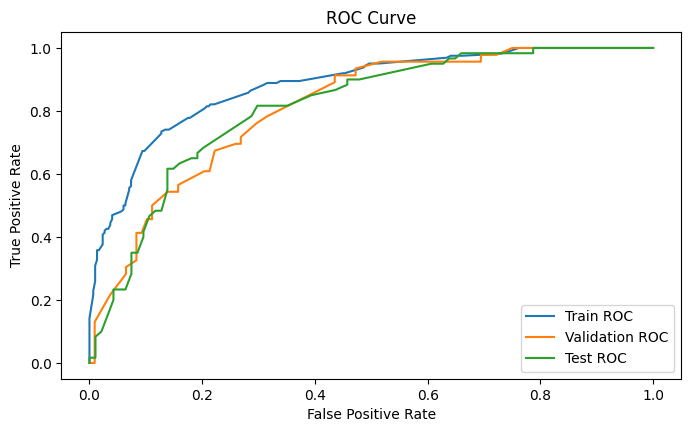

In [23]:
train_roc = roc_curve(results_train['Target'], results_train['True Prob'])
val_roc = roc_curve(results_val['Target'], results_val['True Prob'])
test_roc = roc_curve(results_test['Target'], results_test['True Prob'])

plt.figure(figsize=[8,4.5])
plt.plot(train_roc[0], train_roc[1], label='Train ROC')
plt.plot(val_roc[0], val_roc[1], label='Validation ROC')
plt.plot(test_roc[0], test_roc[1], label='Test ROC')
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

Next we look at our Confusion Matrix. We can see that when we predict negative, we get a true negative about 70% of the time and a false negative about 30% of the time. When we predict positive, we get a false positive about 25% of the time and a true positive about 75% of the time. This is a balanced model because our false positive rate and our false negative rate are about the same.

In [24]:
conf_mat = confusion_matrix(results_test['Target'], results_test['Prediction'], normalize='pred')
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = pd.MultiIndex.from_tuples([('Predicted Values', 'Negative'), ('Predicted Values', 'Positive')])
conf_mat.index = pd.MultiIndex.from_tuples([('Actual Values', 'Negative'), ('Actual Values', 'Positive')])
round(conf_mat * 100, 2).astype(str) + '%'

Predicted Values         
                               Negative Positive
Actual Values Negative           72.41%   26.32%
              Positive           27.59%   73.68%